✅ All imports successful!

--- Step 1: Loading Configuration ---

🔍 Validating Paths and Hardware...
✅ GPU found: NVIDIA GeForce RTX 4050 Laptop GPU
✅ Metadata file found.
✅ Best model file found.

✅ Configuration is ready.

--- Step 2: Defining Helper Functions and Classes ---
✅ Helper components defined.

--- Step 3: Starting Final Evaluation on Test Set ---
✅ Best model loaded from 'unetplusplus_efficientnet-b7_best_model.pth' and set to evaluation mode.
✅ Test DataLoader ready with 2723 images.

--- Visualizing Predictions on Unseen Test Data ---


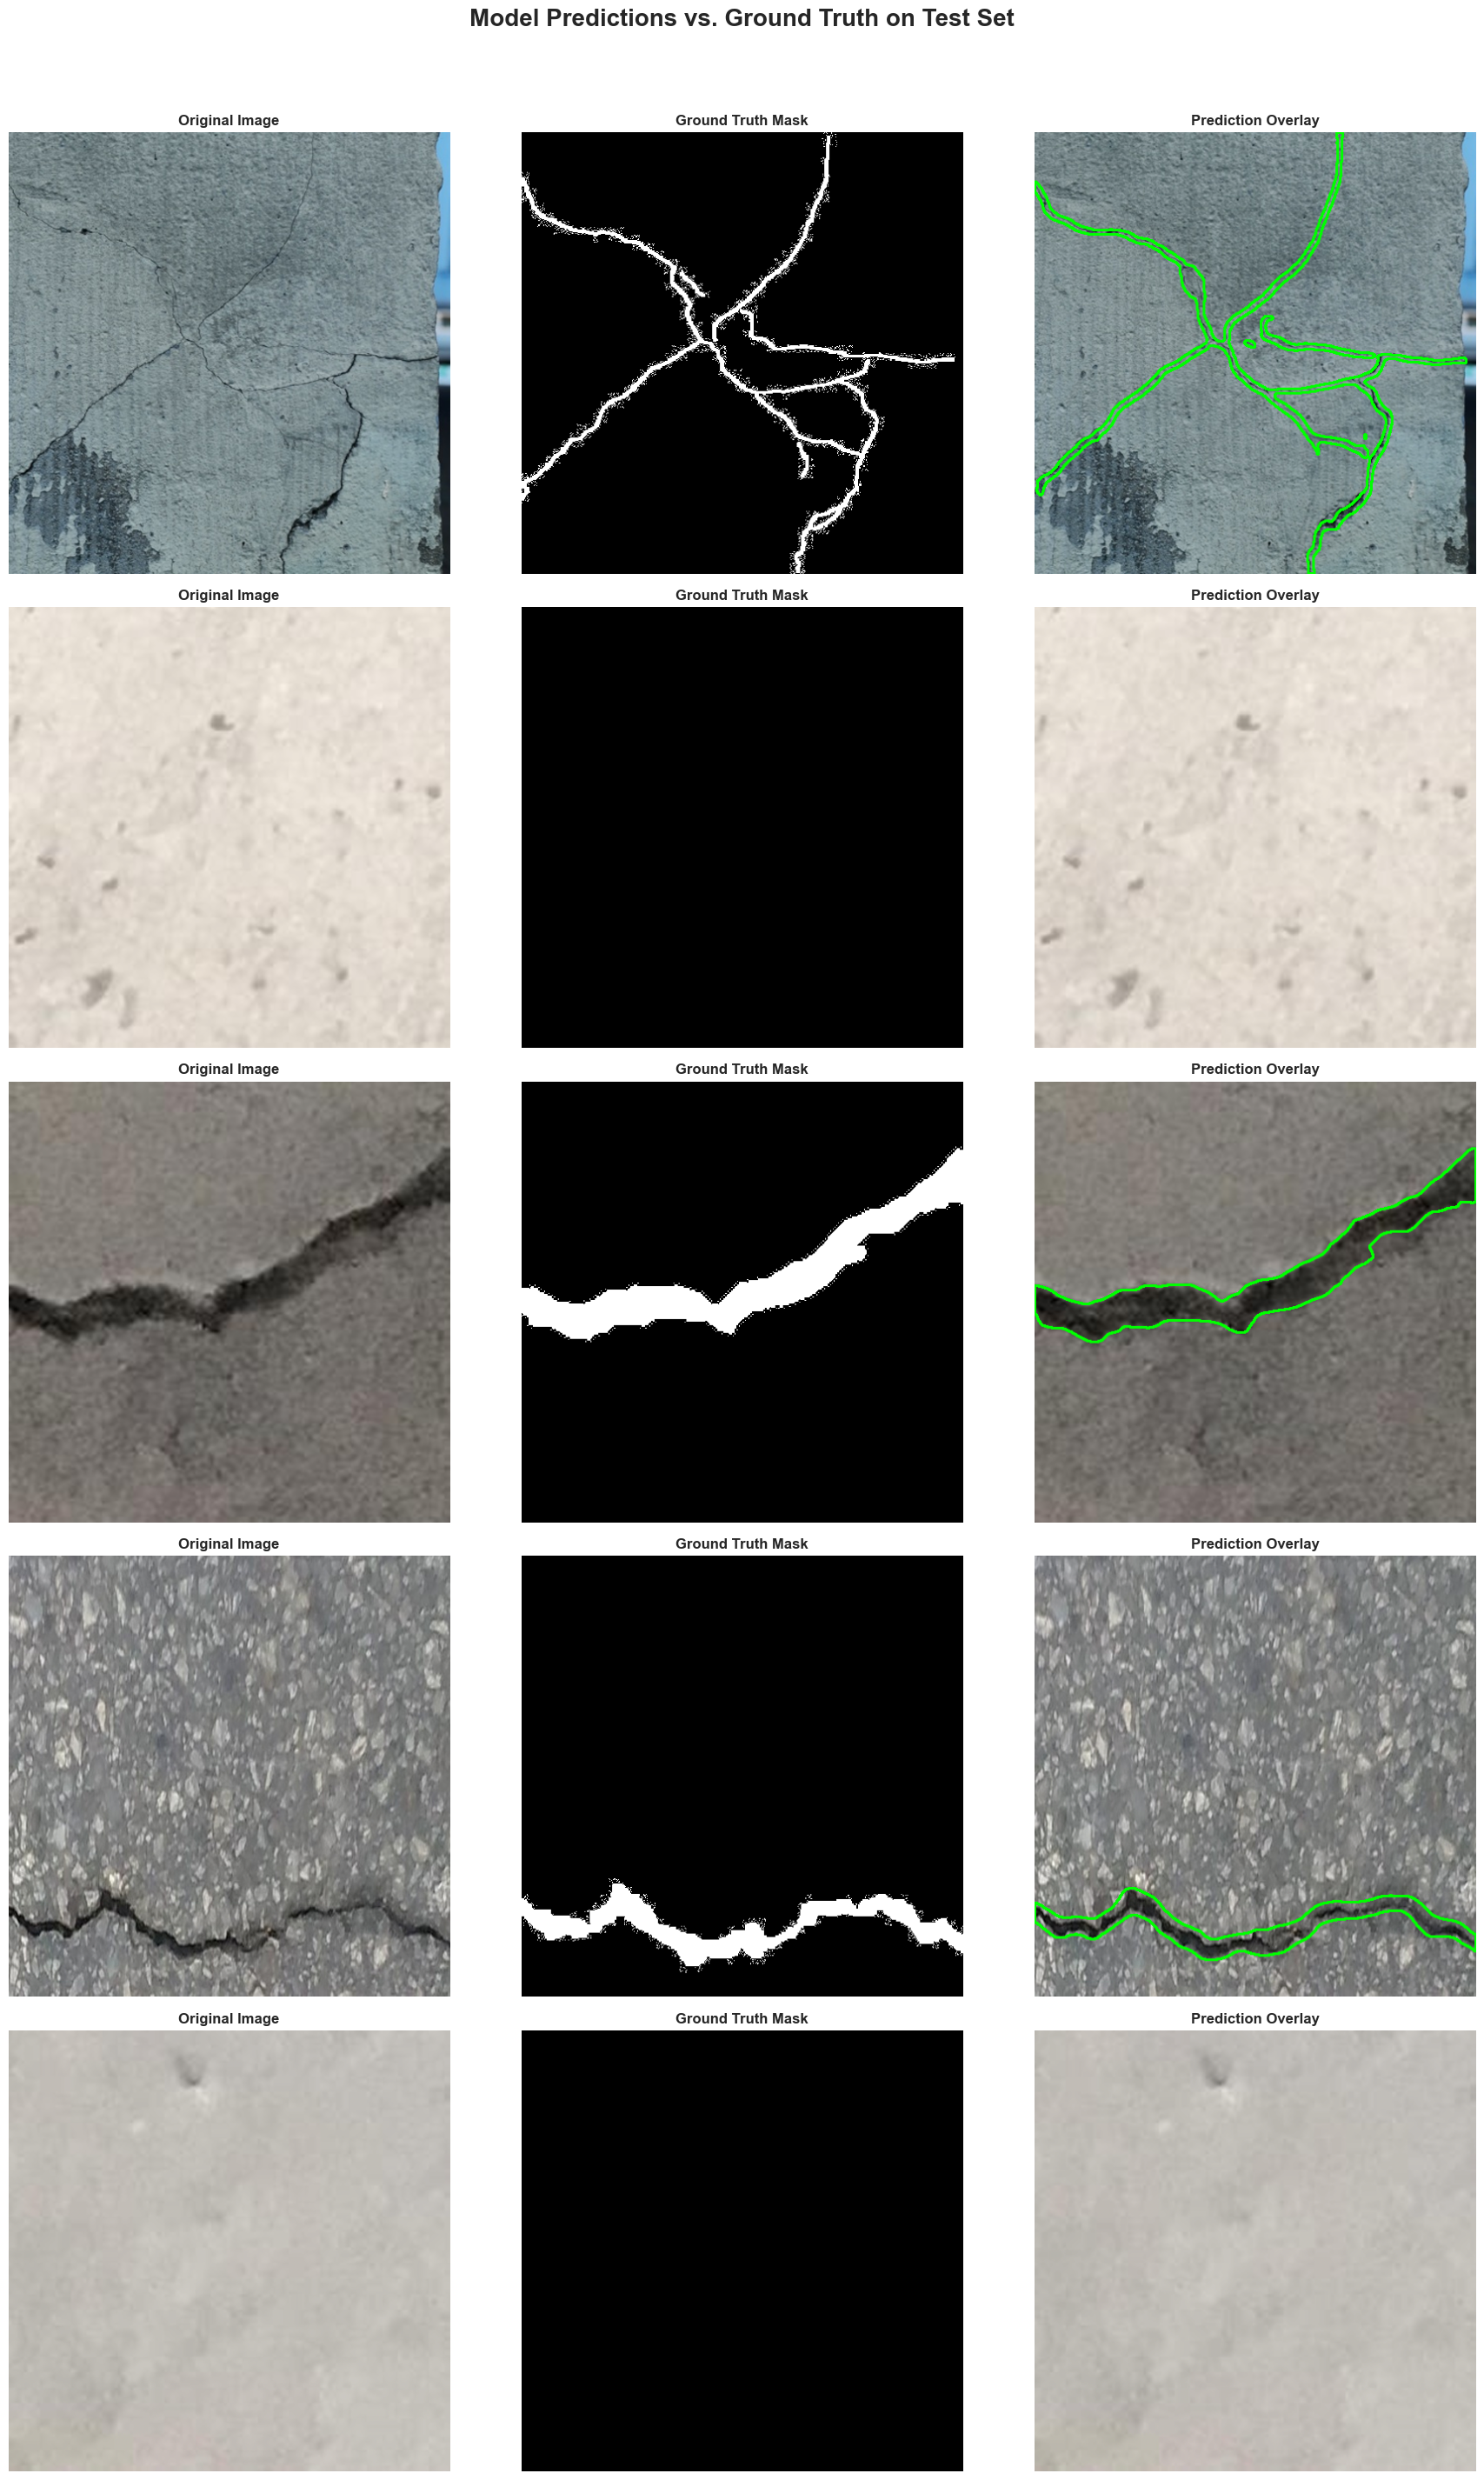

In [ ]:

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm.notebook import tqdm
import os
import warnings
from PIL import Image 

warnings.filterwarnings('ignore')

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (18, 6)
print("All imports successful!")



print("\n--- Step 1: Loading Configuration ---")


DATA_DIR = Path(r"")
METADATA_PATH = DATA_DIR / "metadata.csv"
MODEL_PATH = DATA_DIR / "unetplusplus_efficientnet-b7_best_model.pth"


MODEL_ARCHITECTURE = "unetplusplus"
ENCODER_BACKBONE = "efficientnet-b7"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMAGE_SIZE = 512


BATCH_SIZE = 8 
NUM_WORKERS = 0 
NUM_SAMPLES_TO_DISPLAY = 5 


print("\n🔍 Validating Paths and Hardware...")
if DEVICE == "cuda":
    print(f" GPU found: {torch.cuda.get_device_name(0)}")
else:
    print(" WARNING: No GPU found. Evaluation will run on the CPU.")

if not METADATA_PATH.exists():
    raise FileNotFoundError(f" ERROR: Metadata file not found at '{METADATA_PATH}'")
else:
    print(" Metadata file found.")
    
if not MODEL_PATH.exists():
    raise FileNotFoundError(f" ERROR: Model file not found at '{MODEL_PATH}'")
else:
    print(f" Best model file found.")

print("\n Configuration is ready.")



print("\n--- Step 2: Defining Helper Functions and Classes ---")


val_test_transforms = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])


class CrackDataset(Dataset):
    def __init__(self, dataframe, transforms=None):
        self.df = dataframe
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = cv2.imread(row['image_path'])
        if image is None:
            print(f"Warning: Could not read image {row['image_path']}")
            return None
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(row['mask_path'], cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"Warning: Could not read mask {row['mask_path']}")
            return None

        if self.transforms:
            augmented = self.transforms(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']
            
        return image, mask.unsqueeze(0).float()


def collate_fn(batch):
    batch = list(filter(lambda x: x is not None and x[0] is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch) if batch else (None, None)

print("✅ Helper components defined.")



print("\n--- Step 3: Starting Final Evaluation on Test Set ---")


try:
    import segmentation_models_pytorch as smp
except ImportError:
    raise ImportError("Please install: pip install segmentation-models-pytorch")

model = smp.UnetPlusPlus(
    encoder_name=ENCODER_BACKBONE,
    encoder_weights=None,
    in_channels=3,
    classes=1,
)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()
print(f" Best model loaded from '{MODEL_PATH.name}' and set to evaluation mode.")


df = pd.read_csv(METADATA_PATH)
test_df = df[df['split'] == 'test'].reset_index(drop=True)
test_dataset = CrackDataset(test_df, transforms=val_test_transforms)
test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)
print(f"Test DataLoader ready with {len(test_dataset)} images.")


print("\n--- Visualizing Predictions on Unseen Test Data ---")

with torch.no_grad():
    images, masks = next(iter(test_loader))
    
    if images is not None:
        images = images.to(DEVICE)
        predictions = model(images)
        binary_preds = (torch.sigmoid(predictions) > 0.5).float()

        images, masks, binary_preds = images.cpu(), masks.cpu(), binary_preds.cpu()

     
        num_to_show = min(len(images), NUM_SAMPLES_TO_DISPLAY)
        
        fig, axes = plt.subplots(num_to_show, 3, figsize=(18, num_to_show * 6))
        fig.suptitle("Model Predictions vs. Ground Truth on Test Set", fontsize=20, weight='bold', y=0.95)

        for i in range(num_to_show):
          
            img_display = images[i].permute(1, 2, 0).numpy()
            mean, std = np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225])
            img_display = std * img_display + mean
            img_display = np.clip(img_display, 0, 1)
            
            
            overlay_image = (img_display * 255).astype(np.uint8)
            overlay_image = cv2.cvtColor(overlay_image, cv2.COLOR_RGB2BGR) 

            
            pred_mask_np = binary_preds[i].squeeze().numpy().astype(np.uint8)
            
          
            contours, _ = cv2.findContours(pred_mask_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            cv2.drawContours(overlay_image, contours, -1, (0, 255, 0), 2) 
         
            
            overlay_image_rgb = cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB) 

          
            ax_img = axes[i, 0] if num_to_show > 1 else axes[0]
            ax_img.imshow(img_display)
            ax_img.set_title("Original Image", weight='bold')
            ax_img.axis('off')
          
            ax_mask = axes[i, 1] if num_to_show > 1 else axes[1]
            ax_mask.imshow(masks[i].squeeze(), cmap='gray')
            ax_mask.set_title("Ground Truth Mask", weight='bold')
            ax_mask.axis('off')
            
       
            ax_pred = axes[i, 2] if num_to_show > 1 else axes[2]
            ax_pred.imshow(overlay_image_rgb)
            ax_pred.set_title("Prediction Overlay", weight='bold')
            ax_pred.axis('off')

        plt.tight_layout(rect=[0, 0, 1, 0.93])
        plt.show()
    else:
        print(" Could not load a valid batch of images. Please check file paths.")

